In [275]:
import sys
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import csv

import pandas as pd
import itertools

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset



In [276]:
# Geometry
length = 15e-2              # Length of the rod

# Material properties
rho = 2760.0                      # Density of AL380 (kg/m^3)

k = 109.0                        # W/m-K
                       # W/m-K
cp = 963.0                        # Specific heat of aluminum (J/kg-K)

alpha = k / (rho * cp)            # Thermal diffusivity

# print('alpha ia',alpha)
#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg

# Spatial discretization

num_points = 50                  # Number of spatial points
dx = length / (num_points - 1)
print('dx is',dx)
                                   #dt = time_end/num_steps
#num_steps = 200000               # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
# Time Discretization  
# 
time_end = 10               # seconds                         
#num_steps = 10000
# dt = time_end/num_steps
dt = abs(0.5 *(dx**2/alpha))
print('dt is ',dt)
num_steps = round(time_end/dt) +1
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/alpha)
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

dx is 0.003061224489795918
dt is  0.11425342651571017
num_steps is 89
cfl is 0.11425342651571017
stability criteria satisfied


In [277]:
# Initial Conditions
T_L = 866.0                       #  K -Liquidus Temperature (593 c)
T_S = 811.0                       # K- Solidus Temperature (538 C)


# Initial temperature and phase fields
init_temp = 870.0
temperature = np.full(num_points, init_temp)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1.0

temperature[0] = 313.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

#print(temperature_history,phi_history)

In [278]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
    for n in range(1,num_points-1):              # space loop, adjusted range
        #print(f"Step {m}, point {n},Temperature: {temperature}, Phase: {phase}")
        temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
        
    
    temperature_history.append(temperature.copy())
    phi_history.append(phase.copy())
    #Print for debugging
    # print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")


#print(temperature_history)
#print(phi_history)




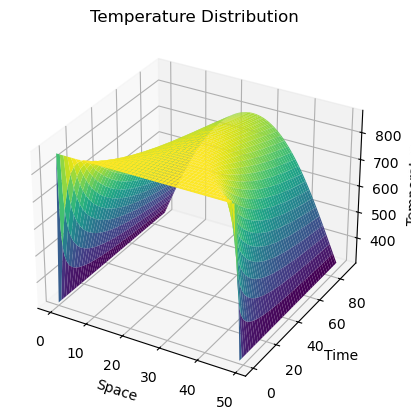

In [279]:
from mpl_toolkits.mplot3d import Axes3D

temperature_history_a = np.array(temperature_history) 
phi_history_a = np.array(phi_history)

time_steps = temperature_history_a.shape[0]
spatial_poitns = temperature_history_a.shape[1]

time = np.arange(time_steps)
space = np.arange(spatial_poitns)

T,X = np.meshgrid(time,space, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,T,temperature_history_a, cmap='viridis')

ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.set_title('Temperature Distribution')

plt.show()

In [280]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [281]:

# Define the neural network architecture
class HeatPINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # This is the constructor
        super(HeatPINN, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Softplus(),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x, t):                               # This is the forward pass
        input_features = torch.cat([x, t], dim=1)          # Concatenate the input features
        m = self.base(input_features)                                 # Pass through the third layer
        return m                    # Return the output of the network


# features = torch.rand(1, 2)
# model = HeatPINN(2, 20, 1)
# output = model(features[:, 0:1], features[:, 1:2])
# print(output)


# Loss function for data 


Preparing the data for Aye Eye

In [282]:

# Training data preparation
x = torch.linspace(0, length, num_points).view(-1, 1).requires_grad_(True) # Spatial dimension of length l
t = torch.linspace(0, time_end, num_steps+1).view(-1, 1).requires_grad_(True)# Temporal dimension of length T
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij') # Create a meshgrid of X and T

X = X.reshape(-1, 1)  # Reshape X to a column vector
T = T.reshape(-1, 1)   # Reshape T to a column vector


In [283]:



inputs = torch.cat([X, T], dim=1).to(device) # Concatenate the spatial and temporal inputs

temp_t = torch.tensor(np.array(temperature_history)).to(device) # Convert the temperature history to a tensor
# phase_t = torch.tensor(np.array(phi_history)).to(device)         # Convert the phase history to a tensor
temp_inp = temp_t.reshape(-1,1) # Reshape the temperature tensor to a column vector
# phase_inp = phase_t.reshape(-1,1) # Reshape the temperature tensor to a column vector


#Data Splitting

train_inputs, val_test_inputs, train_temp_inp, val_test_temp_inp = train_test_split(inputs, temp_inp, test_size=0.2, random_state=42)
val_inputs, test_inputs, val_temp_inp, test_temp_inp = train_test_split(val_test_inputs, val_test_temp_inp, test_size=0.5, random_state=42)




Create the custom data set for the training from 

In [284]:


# class  SpatiotemporalDataset(torch.utils.data.Dataset):
#     def __init__(self, inputs, temp_inp, transform = None, target_transform = None):
#         self.inputs = inputs
#         self.temp_inp = temp_inp
        

#     def __getitem__(self, index):
#         return self.inputs[index], self.temp_inp[index]

#     def __len__(self):
#         return len(self.inputs)

# # Create the dataset and dataloader   

# train_dataset = SpatiotemporalDataset(train_inputs, train_temp_inp)

# val_dataset = SpatiotemporalDataset(val_inputs, val_temp_inp)
# test_dataset = SpatiotemporalDataset(test_inputs, test_temp_inp)


# train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)



In [285]:


class SpatiotemporalDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, temp_inp, mean=None, std=None, transform=None, target_transform=None):
        self.inputs = inputs
        self.temp_inp = temp_inp
        self.transform = transform
        self.target_transform = target_transform
        
        if mean is None or std is None:
            self.mean = np.mean(inputs, axis=0)
            self.std = np.std(inputs, axis=0)
        else:
            self.mean = mean
            self.std = std

    def __getitem__(self, index):
        input_data = (self.inputs[index] - self.mean) / self.std
        temp_data = (self.temp_inp[index] - self.mean) / self.std
        if self.transform:
            input_data = self.transform(input_data)
        if self.target_transform:
            temp_data = self.target_transform(temp_data)
        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(temp_data, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)



# Calculate mean and std from the training data
mean = train_inputs.mean(dim=0)
std = train_inputs.std(dim=0)

# Create the dataset and dataloader
train_dataset = SpatiotemporalDataset(train_inputs, train_temp_inp, mean=mean, std=std)
val_dataset = SpatiotemporalDataset(val_inputs, val_temp_inp, mean=mean, std=std)
test_dataset = SpatiotemporalDataset(test_inputs, test_temp_inp, mean=mean, std=std)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Example of iterating through the dataloader
# for inputs, temp_inp in train_dataloader:
#     print(inputs, temp_inp)


In [286]:
def pde_loss(u,u_t,u_xx,alpha):
    residual = u_t - alpha * u_xx
    return nn.MSELoss()(residual,torch.zeros_like(residual))

def boundary_loss(u_left,u_right,boundary_value):
    return torch.mean((u_left - boundary_value)**2 + (u_right - boundary_value)**2)

def initial_condition_loss(u_initial,initial_value):
    return torch.mean((u_initial - initial_value)**2)


def loss_fn_data(u_pred, u_true):
    return nn.MSELoss()(u_pred, u_true)

def l1_regularization(model, lambda_):
    l1_reg = sum(param.abs().sum() for param in model.parameters())
    return l1_reg

In [287]:
# Hyperparameters
hidden_size = 300
learning_rate = 0.08
epochs = 30000
# alpha = 0.01  # Adjust this value based on your problem
boundary_value = 313.0
initial_value = init_temp
# Initialize the model
model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1).to(device)
lambda_l1 = 0.2

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [288]:
train_losses = []
val_losses = []
test_losses = []


Training Function

In [289]:
def training_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, val_dataloader):
    train_losses = []  # Initialize the list to store the training losses
    val_losses = []    # Initialize the list to store the validation losses

    for epoch in range(epochs):
        model.train()                 # Set the model to training mode
        train_loss = 0                # Initialize the training loss

        for batch in train_dataloader:              # Loop through the training dataloader
            inputs, temp_inp= batch                 # Get the inputs and the true values
            inputs, temp_inp= inputs.to(device), temp_inp.to(device) # Move the inputs and true values to the GPU
            optimizer.zero_grad()                               # Zero the gradients
            
            # Forward pass
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1)).to(device) # Get the predictions
            
            # Loss calculation
            data_loss = loss_fn_data(u_pred, temp_inp.float())                                  # Calculate the data loss
            l1_regularization_loss = l1_regularization(model, lambda_l1)                  # Calculate the L1 regularization loss
            loss = data_loss + l1_regularization_loss                                      # Calculate the total loss
            
            # Backpropagation
            loss.backward(retain_graph=True)                             # Backpropagate the gradients
            
            optimizer.step()                                                   # Update the weights
            
            train_loss += loss.item()     
                                        # Add the loss to the training set loss
        train_losses.append(train_loss)                               # Append the training loss to the list of training losses
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Training-Loss {train_loss}")
        
        model.eval()
        val_loss = 0                                                                     # Initialize the validation loss
        
        with torch.no_grad():
            for batch in val_dataloader:                                                            # Loop through the validation dataloader
                inputs, temp_inp= batch                                                        # Get the inputs and the true values
                inputs, temp_inp= inputs.to(device), temp_inp.to(device)                                     # Move the inputs and true values to the GPU
                u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))                        # Get the predictions
                data_loss = loss_fn_data(u_pred, temp_inp.float())                                          # Calculate the data loss
                loss = data_loss                                                                          # Calculate the total loss
                val_loss += loss.item()                                                                     # Add the loss to the validation set loss
            val_losses.append(val_loss)                                                                 # Append the validation loss to the list of validation losses
                                                                        # Append the validation loss to the list of validation losses
    return train_losses, val_losses                                                                    # Return the training and validation losses


Validation Function

In [290]:
def test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader):
      
    model.eval()
    test_loss = 0
    with torch.no_grad():   
        for batch in test_dataloader:
            inputs, temp_inp= batch
            inputs, temp_inp= inputs.to(device), temp_inp.to(device)
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
            data_loss = loss_fn_data(u_pred, temp_inp.float())
            loss = data_loss 
            test_loss += loss.item()
        test_losses.append(test_loss)
    if epochs % 10 == 0:
        print(f"Epoch {epochs}, Test-Loss {test_loss}")    
    return test_losses

In [291]:

train_losses = training_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, val_dataloader)  # Train the model
 
test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader)  # Test the model
train_losses.append(train_losses)

test_losses.append(test_losses)

   


    
    

/tmp/ipykernel_3796536/1942127990.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(temp_data, dtype=torch.float32)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 2])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 2])) that is different to the input size (torch.Size([16, 1])). This will likely lea

Epoch 0, Training-Loss 5839703752.0
Epoch 10, Training-Loss 3920671364.0
Epoch 20, Training-Loss 3915902104.0
Epoch 30, Training-Loss 3917099048.0
Epoch 40, Training-Loss 3910466880.0
Epoch 50, Training-Loss 3917466748.0
Epoch 60, Training-Loss 3909323188.0
Epoch 70, Training-Loss 3905154240.0
Epoch 80, Training-Loss 3900728860.0
Epoch 90, Training-Loss 3918219740.0
Epoch 100, Training-Loss 3912201792.0
Epoch 110, Training-Loss 3903348072.0
Epoch 120, Training-Loss 3891984456.0
Epoch 130, Training-Loss 3900293728.0
Epoch 140, Training-Loss 3889363532.0
Epoch 150, Training-Loss 3896122572.0
Epoch 160, Training-Loss 3887057116.0
Epoch 170, Training-Loss 3884401256.0
Epoch 180, Training-Loss 3873139528.0
Epoch 190, Training-Loss 3884605468.0
Epoch 200, Training-Loss 3896429580.0
Epoch 210, Training-Loss 3884367440.0
Epoch 220, Training-Loss 3901887772.0
Epoch 230, Training-Loss 3888095260.0
Epoch 240, Training-Loss 3884688468.0
Epoch 250, Training-Loss 3856102772.0
Epoch 260, Training-Los

AttributeError: 'tuple' object has no attribute 'append'

In [ ]:
# torch.save(model.state_dict(), 'model.pth')

# # Load the model
# model = HeatPINN(input_size=2, hidden_size=hidden_size, output_size=1).to(device)
# model.load_state_dict(torch.load('model.pth'))
# model.to(device)

In [ ]:
test_loss = test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader)
print(f"Test Loss: {test_loss}")

 #plotting the loss
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
x = torch.tensor([[0.0]],dtype=torch.float32).to(device)
y = torch.tensor([[0.0]],dtype=torch.float32).to(device)

y_o = model(x,y)
print(y_o)